In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/bookcrossing'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/reads.pkl','rb'))

## Dataset and DataLoader

In [4]:
df_train.shape,df_valid.shape

((105284, 340557), (105284, 340557))

In [5]:
df_train[1]

<1x340557 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [6]:
df_train[1].todense().shape

(1, 340557)

In [7]:
df_train[1].todense().getA1().shape

(340557,)

In [8]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX[idx].todense().getA1()),torch.FloatTensor(self.dfXv[idx].todense().getA1())

In [9]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [39]:
bs=32

In [40]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [12]:
df_train.min(),df_train.max()

(0, 10)

In [13]:
df_train.shape

(105284, 340557)

In [41]:
len(dltrain)

3291

## Create the Model Architecture for the Encoder

In [15]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [16]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp=9724,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [17]:
n_final_user=10 # 3 for IMDB

In [18]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*5,n_final_user],[0,0,0])

In [19]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=340557, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=50, out_features=340557, bias=True)
  (criterion): MSELoss()
)

In [20]:
for Xb,Xb_v in dltrain:
    print (Xb)
    break

tensor([[7., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 9.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [21]:
Xb.size()

torch.Size([64, 340557])

In [22]:
Xb.squeeze(0)

tensor([[7., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 9.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [23]:
preds,loss,_=autoenc.forward(Xb)

In [24]:
loss.backward()

In [25]:
preds.size()

torch.Size([64, 340557])

In [26]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [27]:
device="cuda:1"

In [28]:
wd=1e-4
#wd=1e-1

In [29]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [42]:
len(dltrain)

3291

In [31]:
import matplotlib.pyplot as plt

In [43]:
dltrain.batch_size

32

In [33]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [34]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*5,n_final_user],[0,0,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)

In [35]:
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [36]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=340557, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0)
    )
  )
  (fc): Linear(in_features=50, out_features=340557, bias=True)
  (criterion): MSELoss()
)

In [44]:
len(dltrain),dltrain.batch_size

(3291, 32)

In [45]:
learner.lr_find(1e-4,3e-1,dltrain,len(dltrain))

Batch:1000 7.54321813583374 7.528762340545654 
Batch:2000 7.25681209564209 6.9202752113342285 
Batch:3000 7.312694549560547 6.34233283996582 


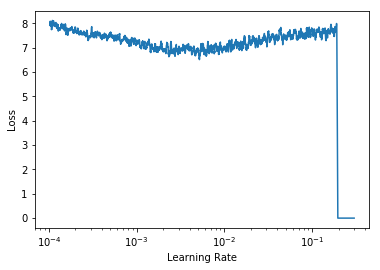

In [46]:
learner.plot_lrs(10)

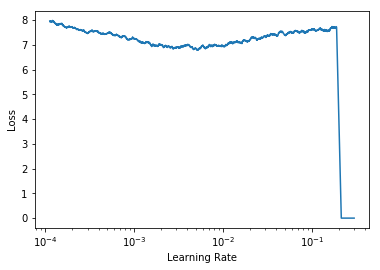

In [48]:
learner.plot_lrs(50)

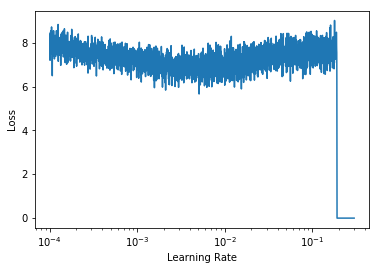

In [47]:
learner.plot_lrs(1)

In [49]:
del autoenc
torch.cuda.empty_cache()

In [50]:
autoenc=autoencoder(df_train.shape[1],[n_final_user*5,n_final_user],[0,0,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=3e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=1e-1,end_lr=5e-2)

In [51]:
learner.run_epochs(dltrain,None,5)

Batch:1000 6.377694129943848 6.369375228881836 
Batch:2000 6.549596309661865 6.20529842376709 
Batch:3000 6.724046230316162 5.779583930969238 
Epoch:0 Learning rate 0.003 Weight Decay 1e-07 Train Loss:6.357002258300781  Valid Loss:5.805510997772217 
Batch:1000 6.079492568969727 6.069525241851807 
Batch:2000 6.41641902923584 6.071987152099609 
Batch:3000 6.638473987579346 5.693522930145264 
Epoch:1 Learning rate 0.003 Weight Decay 1e-07 Train Loss:6.279159069061279  Valid Loss:5.728314399719238 
Batch:1000 6.083498001098633 6.073962688446045 
Batch:2000 6.418981075286865 6.074768543243408 
Batch:3000 6.640202522277832 5.695403099060059 
Epoch:2 Learning rate 0.003 Weight Decay 1e-07 Train Loss:6.280731201171875  Valid Loss:5.729817867279053 
Batch:1000 6.082863807678223 6.073360443115234 
Batch:2000 6.418731212615967 6.074535369873047 
Batch:3000 6.640064239501953 5.695267677307129 
Epoch:3 Learning rate 0.003 Weight Decay 1e-07 Train Loss:6.280608177185059  Valid Loss:5.729799747467041

In [55]:
torch.save(autoenc,f=f'{DATAPATH}/inter/user_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/user_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/user_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/user_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/user_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [56]:
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=2e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=5e-4)

In [57]:
learner.run_epochs(dltrain,None,7)

Batch:1000 6.4362077713012695 6.42724084854126 
Batch:2000 6.537877082824707 6.194092750549316 
Batch:3000 6.702549457550049 5.759703636169434 
Epoch:0 Learning rate 0.002 Weight Decay 1e-07 Train Loss:6.336617469787598  Valid Loss:5.783513069152832 
Batch:1000 6.1600799560546875 6.144649505615234 
Batch:2000 6.324344158172607 5.977661609649658 
Batch:3000 6.528779029846191 5.5879693031311035 
Epoch:1 Learning rate 0.001 Weight Decay 1e-07 Train Loss:6.176109790802002  Valid Loss:5.6214375495910645 
Batch:1000 6.405012130737305 6.3922529220581055 
Batch:2000 6.409337043762207 6.063464164733887 
Batch:3000 6.526645660400391 5.594598770141602 
Epoch:2 Learning rate 0.0005 Weight Decay 1e-07 Train Loss:6.168493747711182  Valid Loss:5.615687847137451 
Batch:1000 6.034663200378418 6.023751735687256 
Batch:2000 6.360305309295654 6.017098903656006 
Batch:3000 6.591813087463379 5.6488847732543945 
Epoch:3 Learning rate 0.002 Weight Decay 1e-07 Train Loss:6.235991954803467  Valid Loss:5.6854581

In [58]:
torch.save(autoenc,f=f'{DATAPATH}/inter/user_autoenc')
torch.save(learner,f=f'{DATAPATH}/inter/user_autoenc_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/user_autoenc_optimizer')
torch.save(autoenc.state_dict(),f'{DATAPATH}/inter/user_autoenc_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/user_autoenc_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [59]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([50, 340557])

In [60]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 50])

In [61]:
user_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
user_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [62]:
from scipy.special import expit

df_train_user_autoenc=np.tanh(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=np.tanh(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [63]:
df_train_user_autoenc=(expit(df_train@user_mtx_1_weights.T)@user_mtx_2_weights.T)
df_valid_user_autoenc=(expit(df_valid@user_mtx_1_weights.T)@user_mtx_2_weights.T)

In [64]:
df_train_user_autoenc.shape,df_valid_user_autoenc.shape

((105284, 10), (105284, 10))

In [65]:
df_train_user_autoenc=pd.DataFrame(df_train_user_autoenc)

In [66]:
df_train_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_train_user_autoenc.shape[1])]

In [67]:
df_valid_user_autoenc=pd.DataFrame(df_valid_user_autoenc)

In [68]:
df_valid_user_autoenc.columns=['user_autoenc'+str(i) for i in range(df_valid_user_autoenc.shape[1])]

In [69]:
df_train_user_autoenc.reset_index(inplace=True)
df_valid_user_autoenc.reset_index(inplace=True)

In [70]:
df_train_user_autoenc.rename({'index':'user_idx'},axis=1,inplace=True)

In [71]:
df_valid_user_autoenc.rename({'index':'user_idx'},axis=1,inplace=True)

In [72]:
df_train_user_autoenc.head()

,user_idx,user_autoenc0,user_autoenc1,user_autoenc2,user_autoenc3,user_autoenc4,user_autoenc5,user_autoenc6,user_autoenc7,user_autoenc8,user_autoenc9
0,0,1.425841,1.425767,1.425770,-1.425792,1.425769,1.425740,-1.425740,1.425776,-1.425954,-1.425764
1,1,1.432288,1.432213,1.432216,-1.432238,1.432215,1.432186,-1.432186,1.432222,-1.432401,-1.432210
2,2,1.426912,1.426838,1.426840,-1.426862,1.426840,1.426811,-1.426811,1.426847,-1.427025,-1.426835
3,3,1.430663,1.430588,1.430591,-1.430613,1.430590,1.430561,-1.430561,1.430598,-1.430776,-1.430585
4,4,1.427409,1.427335,1.427337,-1.427359,1.427336,1.427308,-1.427308,1.427344,-1.427522,-1.427332


In [73]:
import pickle
pickle.dump([df_train_user_autoenc,df_valid_user_autoenc,user_mtx_1_weights,user_mtx_2_weights],open(f'{DATAPATH}/inter/user_autoenc_weights.pkl','wb'))

In [74]:
autoenc.encoder

Sequential(
  (0): Sequential(
    (0): Linear(in_features=340557, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0)
  )
  (1): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0)
  )
)

In [75]:
df_train_user_autoenc.shape

(105284, 11)